In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ferramentas de Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Carregar a tabela de modelagem v2 (com features de CMO e Disponibilidade)
path_final_table = '../data/processed/modeling_table_v2.parquet'
df = pd.read_parquet(path_final_table)
print(f"Tabela de modelagem final carregada com {df.shape[0]} dias e {df.shape[1]} colunas.")

# 1. Separar Features (X) e Alvo (y)
y = df['nivel_risco']
X = df.drop(columns=['nivel_risco', 'deficit_diario_mwh'])

# 2. Codificar o Alvo e Dividir em Treino/Teste
print("\n--- Contagem de dias por classe de risco ---")
print(y.value_counts())
mapeamento_risco = {'baixo': 0, 'medio': 1, 'alto': 2}
y_encoded = y.map(mapeamento_risco)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# 3. Escalonar as Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicar SMOTE nos dados de treino
print("\n--- Aplicando SMOTE nos dados de treino ---")
print("Contagem de classes de treino ANTES do SMOTE:")
print(y_train.value_counts())
min_class_count = y_train.value_counts().min()
k_neighbors_smote = max(1, min_class_count - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("\nContagem de classes de treino DEPOIS do SMOTE:")
print(y_train_resampled.value_counts())

print("\nPreparação dos dados concluída.")

Tabela de modelagem final carregada com 1343 dias e 22 colunas.

--- Contagem de dias por classe de risco ---
nivel_risco
baixo    1315
medio      18
alto       10
Name: count, dtype: int64

--- Aplicando SMOTE nos dados de treino ---
Contagem de classes de treino ANTES do SMOTE:
nivel_risco
0    920
1     13
2      7
Name: count, dtype: int64

Contagem de classes de treino DEPOIS do SMOTE:
nivel_risco
0    920
2    920
1    920
Name: count, dtype: int64

Preparação dos dados concluída.


In [3]:
# Definimos os parâmetros que queremos testar para o XGBoost
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5]
}

# Instancia o modelo base
xgb = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, eval_metric='mlogloss')

print("Grid de hiperparâmetros definido.")

Grid de hiperparâmetros definido.


In [4]:
# Configuração da busca aleatória
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,  # Testa 50 combinações aleatórias
    cv=3,       # Usa validação cruzada com 3 folds
    scoring='f1_weighted', # Métrica de avaliação para dados desbalanceados
    n_jobs=-1,  # Usa todos os processadores
    random_state=42,
    verbose=2
)

# --- ATENÇÃO: ESTA CÉLULA PODE DEMORAR BASTANTE PARA EXECUTAR! ---
print("Iniciando a busca de hiperparâmetros...")
random_search.fit(X_train_resampled, y_train_resampled)
print("Busca de hiperparâmetros concluída.")

Iniciando a busca de hiperparâmetros...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Busca de hiperparâmetros concluída.


In [5]:
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)

print(f"\nMelhor score (f1_weighted) durante a validação cruzada: {random_search.best_score_:.4f}")

# O melhor modelo já treinado está salvo em 'best_estimator_'
best_model = random_search.best_estimator_

Melhores parâmetros encontrados:
{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}

Melhor score (f1_weighted) durante a validação cruzada: 0.9862


Fazendo previsões com o modelo otimizado...

Acurácia do Modelo Otimizado: 94.54%

Relatório de Classificação (Modelo Otimizado):
              precision    recall  f1-score   support

       baixo       0.98      0.96      0.97       395
       medio       0.00      0.00      0.00         5
        alto       0.00      0.00      0.00         3

    accuracy                           0.95       403
   macro avg       0.33      0.32      0.32       403
weighted avg       0.96      0.95      0.95       403



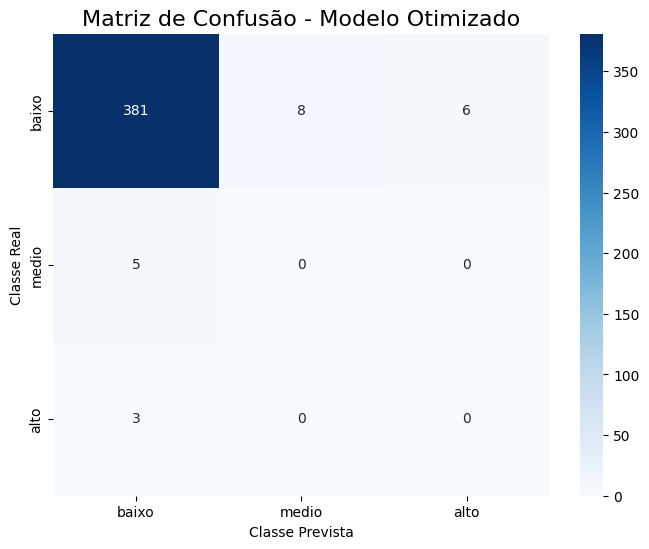

In [6]:
# Agora avaliamos o modelo otimizado nos dados de teste que ficaram guardados.
print("Fazendo previsões com o modelo otimizado...")
y_pred_best = best_model.predict(X_test_scaled)

print(f"\nAcurácia do Modelo Otimizado: {accuracy_score(y_test, y_pred_best):.2%}\n")
print("Relatório de Classificação (Modelo Otimizado):")
print(classification_report(y_test, y_pred_best, target_names=mapeamento_risco.keys()))

# Matriz de Confusão do modelo otimizado
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=mapeamento_risco.keys(), yticklabels=mapeamento_risco.keys())
plt.title('Matriz de Confusão - Modelo Otimizado', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

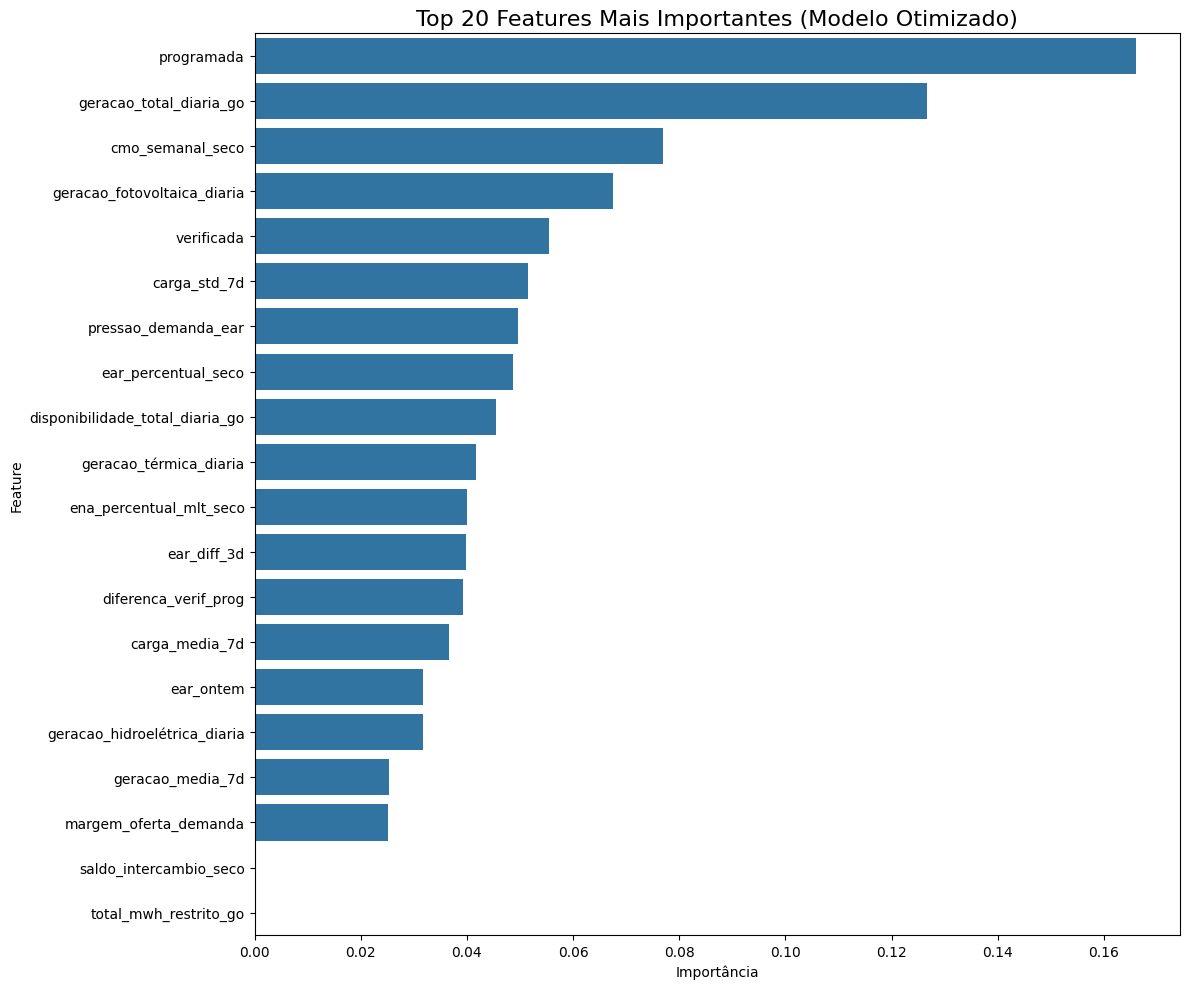

In [7]:
# Vamos ver se as novas features (CMO, Disponibilidade) estão entre as mais importantes.
importances = best_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20)) # Mostra as 20 mais importantes
plt.title('Top 20 Features Mais Importantes (Modelo Otimizado)', fontsize=16)
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()